In [ ]:
import warnings
import datetime

from importlib import reload
from pathlib import Path
from typing import Union, Tuple, List, Dict
from tqdm import tqdm

import numpy as np
from scipy.optimize import Bounds
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


from sdm_eurec4a import RepositoryPath, get_git_revision_hash
from sdm_eurec4a.visulization import (
    set_custom_rcParams,
    adjust_lightness_array,
    ncols_nrows_from_N,
    label_from_attrs,
)
import sdm_eurec4a.input_processing.models as smodels
from sdm_eurec4a.reductions import mean_and_stderror_of_mean
from sdm_eurec4a.identifications import match_clouds_and_cloudcomposite
from sdm_eurec4a.conversions import msd_from_psd_dataarray, psd_from_msd_dataarray

warnings.filterwarnings("ignore")

default_colors = set_custom_rcParams()
dark_colors = adjust_lightness_array(default_colors, 0.7)

Example

In [143]:
class LnParameters:

    def __init__(self, mu, sigma, scale):
        self.parameters = dict(
            mu=mu,
            sigma=sigma,
            scale=scale,
        )

    @property
    def custom_parameters(self):
        """Return the parameters in a dictionary with custom keys.
        Keys are:
        - mu1
        - sigma1
        - scale_factor1
        """
        result = dict(
            mu1=self.parameters["mu"],
            sigma1=self.parameters["sigma"],
            scale_factor1=self.parameters["scale"],
        )
        return result

    @property
    def scipy_parameters(self):
        result = dict(
            s=self.parameters["sigma"],
            loc=self.parameters["mu"],
            scale=self.parameters["scale"],
        )
        return result

    @property
    def geom_parameters(self):
        result = dict(
            geomean=self.parameters["mu"],
            geosig=self.parameters["sigma"],
            scalefac=self.parameters["scale"],
        )
        return result

    @property
    def normal_parameters(self):
        result = dict(
            mu=self.parameters["mu"],
            sigma=self.parameters["sigma"],
            scale=self.parameters["scale"],
        )
        return result


def mass_from_number(t: np.ndarray, y: np.ndarray) -> np.ndarray:
    return 4 / 3 * np.pi * t**3 * y

In [144]:
lower = 1e-2
upper = 100
N = 1000
x = np.linspace(lower, upper, N)
x1 = np.linspace(lower, upper, N * 2)
x2 = np.logspace(np.log10(lower), np.log10(upper), N)
x3 = np.logspace(np.log(lower), np.log(upper), N, base=np.exp(1))

params = LnParameters(3, 2, 3)

results = dict()
for ps in ["direct", "geometric", "exact"]:
    results[ps] = dict()
    for space in ["linear", "ln", "cleo"]:
        results[ps][space] = smodels.log_normal_distribution_all(
            x=x,
            parameter_space=ps,
            space=space,
            mu=params.parameters["mu"],
            sigma=params.parameters["sigma"],
            scale=params.parameters["scale"],
            density_scaled=False,
        )

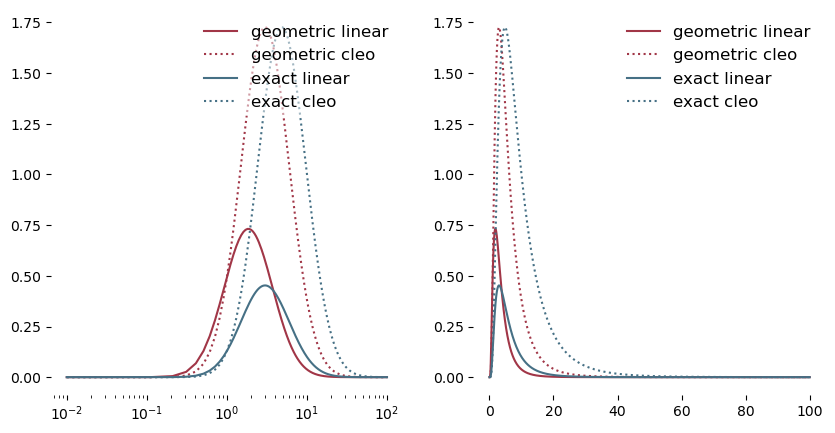

In [145]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axs[0]
ax2 = axs[1]

i = 0
for ps in ["geometric", "exact"]:
    color = dark_colors[i]
    for _ax in axs:
        _ax.plot(x, results[ps]["linear"], label=f"{ps} linear", color=color, linestyle="-")
        # _ax.plot(x, results[ps]['ln'], label=f'{ps} ln', color = color, linestyle='--')
        _ax.plot(x, results[ps]["cleo"], label=f"{ps} cleo", color=color, linestyle=":")
    i += 1

for _ax in axs:
    # _ax.axvline(params.parameters['mu'], color = 'red', linestyle='--')
    # _ax.axhline(params.parameters['scale'], color = 'red', linestyle='--')
    # _ax.axvline(np.log(params.parameters['mu']), color = 'blue', linestyle='--')
    _ax.legend()
# ax2.axvline(10, color = 'k', linestyle='--')
# plt.xlim(xlim)
ax1.set_xscale("log")

# ax1.set_ylim(0, 30)

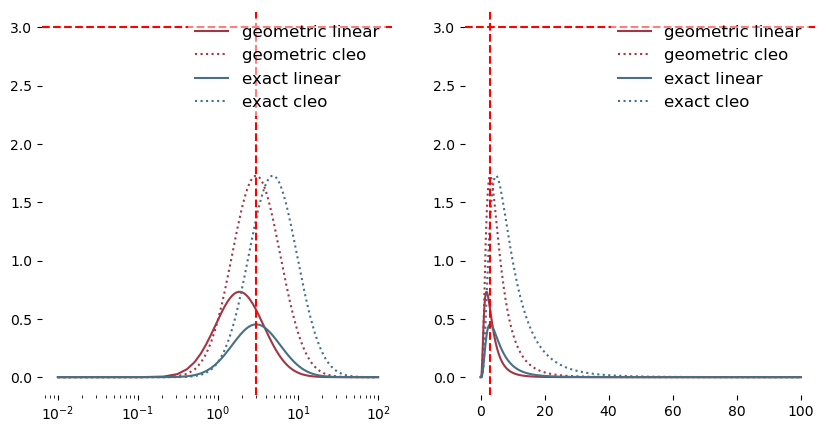

In [146]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axs[0]
ax2 = axs[1]

i = 0
for ps in ["geometric", "exact"]:
    color = dark_colors[i]
    for _ax in axs:
        _ax.plot(x, results[ps]["linear"], label=f"{ps} linear", color=color, linestyle="-")
        # _ax.plot(x, results[ps]['ln'], label=f'{ps} ln', color = color, linestyle='--')
        _ax.plot(x, results[ps]["cleo"], label=f"{ps} cleo", color=color, linestyle=":")
    i += 1

for _ax in axs:
    _ax.axvline(params.parameters["mu"], color="red", linestyle="--")
    _ax.axhline(params.parameters["scale"], color="red", linestyle="--")
    # _ax.axvline(np.log(params.parameters['mu']), color = 'blue', linestyle='--')
    _ax.legend()
# ax2.axvline(10, color = 'k', linestyle='--')
# plt.xlim(xlim)
ax1.set_xscale("log")

# ax1.set_ylim(0, 30)

(0.0, 6.0)

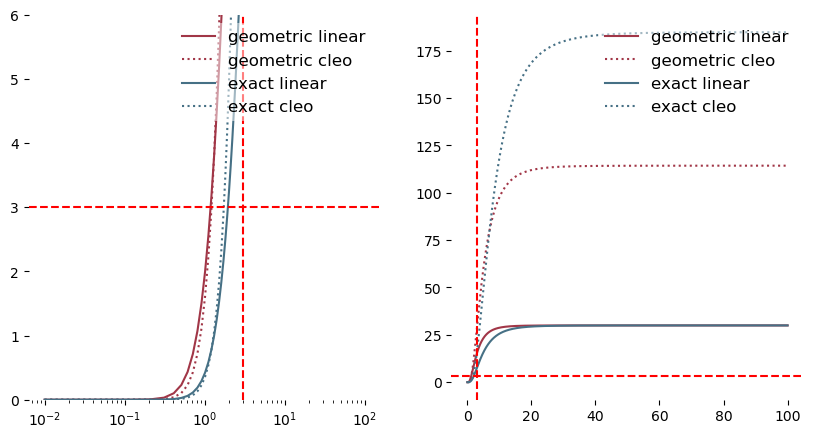

In [147]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axs[0]
ax2 = axs[1]

i = 0
for ps in ["geometric", "exact"]:
    color = dark_colors[i]
    for _ax in axs:
        _ax.plot(x, np.cumsum(results[ps]["linear"]), label=f"{ps} linear", color=color, linestyle="-")
        # _ax.plot(x, results[ps]['ln'], label=f'{ps} ln', color = color, linestyle='--')
        _ax.plot(x, np.cumsum(results[ps]["cleo"]), label=f"{ps} cleo", color=color, linestyle=":")
    i += 1

for _ax in axs:
    _ax.axvline(params.parameters["mu"], color="red", linestyle="--")
    _ax.axhline(params.parameters["scale"], color="red", linestyle="--")
    # _ax.axvline(np.log(params.parameters['mu']), color = 'blue', linestyle='--')
    _ax.legend()
# ax2.axvline(10, color = 'k', linestyle='--')
# plt.xlim(xlim)
ax1.set_xscale("log")

ax1.set_ylim(0, 2 * params.parameters["scale"])

## Import observation data

In [ ]:
data_dir = RepositoryPath("nils_private").get_data_dir()

cloud_composite = xr.open_dataset(
    data_dir / Path("observation/cloud_composite/processed/cloud_composite_SI_units_20241025.nc"),
)
identified_clusters = xr.open_dataset(
    data_dir
    / Path(
        "observation/cloud_composite/processed/identified_clusters/identified_clusters_rain_mask_5.nc"
    )
)
identified_clusters = identified_clusters.swap_dims({"time": "cloud_id"})

# attrs = cloud_composite["radius"].attrs.copy()
# attrs.update({"units": "µm"})
# cloud_composite["radius"] = cloud_composite["radius"]
# cloud_composite["radius_micro"] = 1e6 * cloud_composite["radius"]
# cloud_composite["radius"].attrs = attrs

cloud_composite["radius2D"] = cloud_composite["radius"].expand_dims(time=cloud_composite["time"])
cloud_composite = cloud_composite.transpose("radius", ...)


# cloud_composite = cloud_composite.sel(radius=slice(10e-6, None))

identified_clusters = identified_clusters.where(
    (
        (identified_clusters.duration.dt.seconds >= 3)
        & (identified_clusters.altitude < 1200)
        & (identified_clusters.altitude > 500)
    ),
    drop=True,
)

If we want to coarsen the results, we need to make sure to apply the coarsening on the **NON** normalized data.
Then we can normalized afterwards again

In [ ]:
lower_radius_split = 95e-6  # 50 µm
higher_radius_split = 5e-3  # 1 mm
coarsen_factor = 3

# lower_radius_split = 90e-6  # 50 µm
# higher_radius_split = 0.5e-3  # 1 mm
# coarsen_factor = 3


coarse_composite = cloud_composite.sel(radius=slice(lower_radius_split, higher_radius_split)).copy()

# make sure to have non normalized data to be coarsened
# otherwise, the sum will not be conserved
coarse_composite["particle_size_distribution"] = (
    coarse_composite["particle_size_distribution"] * coarse_composite["bin_width"]
)
coarse_composite["mass_size_distribution"] = (
    coarse_composite["mass_size_distribution"] * coarse_composite["bin_width"]
)

# use mean for radius and radius2D
coarse_composite_radius = coarse_composite["radius"].coarsen(radius=coarsen_factor).mean()
coarse_composite_radius2D = coarse_composite["radius2D"].coarsen(radius=coarsen_factor).mean()
# use the sum for the rest
coarse_composite = coarse_composite.coarsen(radius=coarsen_factor).sum()

coarse_composite["radius"] = coarse_composite_radius
coarse_composite["radius2D"] = coarse_composite_radius2D
coarse_composite["diameter"] = 2 * coarse_composite["radius"]

# make sure to have normalized data again
coarse_composite["particle_size_distribution"] = (
    coarse_composite["particle_size_distribution"] / coarse_composite["bin_width"]
)
coarse_composite["mass_size_distribution"] = (
    coarse_composite["mass_size_distribution"] / coarse_composite["bin_width"]
)

coarse_composite["particle_size_distribution"].attrs = dict(
    long_name="Number concentration",
    unit=cloud_composite["particle_size_distribution"].attrs["unit"],
)
coarse_composite["mass_size_distribution"].attrs = dict(
    long_name="Mass concentration",
    unit=cloud_composite["mass_size_distribution"].attrs["unit"],
)

# merge the two composites with higher resoltion at small radii
# and lower resolution at large radii
coarse_composite = xr.merge(
    [
        coarse_composite.sel(radius=slice(lower_radius_split, higher_radius_split)),
        cloud_composite.sel(radius=slice(None, lower_radius_split)),
        cloud_composite.sel(radius=slice(higher_radius_split, None)),
    ]
)


# Test liquid water content is conserved
np.testing.assert_allclose(
    (coarse_composite["bin_width"] * coarse_composite["mass_size_distribution"]).sum("radius"),
    (cloud_composite["bin_width"] * cloud_composite["mass_size_distribution"]).sum("radius"),
    rtol=0.001,
)
# Test particle concentration is conserved
np.testing.assert_allclose(
    (coarse_composite["bin_width"] * coarse_composite["particle_size_distribution"]).sum("radius"),
    (cloud_composite["bin_width"] * cloud_composite["particle_size_distribution"]).sum("radius"),
    rtol=0.001,
)

## Boundaries for the fitting parameters

Please note, that the value of the fitting parameter are very very sensible!!!

They need to be adjusted with a lot of effort to make the fit work well!

Better bounds are:
````python
class PSDBounds:
    _x0 = np.array([14e-6, 1.5, 1e13, 300e-6, 1.5, 1e3])
    _bounds = Bounds(
        # mu1, sig1, sc1, mu2, sig2, sc2
        lb=[1e-6, 1.3, 1e-20, 100e-6, 1.3, 1e-20],
        ub=[50e6, 3.0, 1e16, 0.5e-3, 3.0, 1e10],
        # keep_feasible = [True, True, True, False, True, True]
    )

    @staticmethod
    def bounds():
        return PSDBounds._bounds

    @staticmethod
    def x0():
        return PSDBounds._x0


class MSDBounds:
    _x0 = np.array([14e-6, 1.5, 1e-1, 300e-6, 2, 1e-4])
    _bounds = Bounds(
        lb=[1e-6, 1.3, 1e-20, 100e-6, 1.3, 1e-20],
        ub=[50e-6, 3.5, 1e2, 0.5e-3, 3.0, 1e1],
        # keep_feasible = [True, True, True, False, True, True]
    )

    @staticmethod
    def bounds():
        return MSDBounds._bounds

    @staticmethod
    def x0():
        return MSDBounds._x0

````

Good bound are:
````python
class PSDBounds():
    _x0 = np.array([3e-6, 1.5, 1e13, 300e-6, 1.5, 1e3])
    _bounds = Bounds(
        # mu1, sig1, sc1, mu2, sig2, sc2
        lb=[1e-6, 1.3, 1e-20, 100e-6, 1.3, 1e-20],
        ub=[50e6, 3.0, 1e16, 0.5e-3, 3.0, 1e10],
        # keep_feasible = [True, True, True, False, True, True]
    )

    @staticmethod
    def bounds():
        return PSDBounds._bounds
    
    @staticmethod
    def x0():
        return PSDBounds._x0
    

class MSDBounds():
    _x0 = np.array([3e-6, 1.5, 1e-1, 300e-6, 2, 1e-4])
    _bounds = Bounds(
        lb=[1e-6, 1.3, 1e-20, 100e-6, 1.3, 1e-20],
        ub=[50e-6, 3.5, 1e2, 0.5e-3, 3.0, 1e1],
        # keep_feasible = [True, True, True, False, True, True]
    ) 

    @staticmethod
    def bounds():
        return MSDBounds._bounds
        
    @staticmethod
    def x0():
        return MSDBounds._x0
````


In [ ]:
class PSDBounds:
    _x0 = np.array([14e-6, 1.5, 1e13, 300e-6, 1.4, 1e3])
    _bounds = Bounds(
        # mu1, sig1, sc1, mu2, sig2, sc2
        lb=[1e-6, 1.3, 1e-20, 100e-6, 1.2, 1e-20],
        ub=[50e6, 3.0, 1e16, 0.5e-3, 2.0, 1e10],
        # keep_feasible = [True, True, True, False, True, True]
    )

    @staticmethod
    def bounds():
        return PSDBounds._bounds

    @staticmethod
    def x0():
        return PSDBounds._x0


class MSDBounds:
    _x0 = np.array([14e-6, 1.5, 1e-1, 300e-6, 1.4, 1e-4])
    _bounds = Bounds(
        lb=[1e-6, 1.3, 1e-20, 100e-6, 1.2, 1e-20],
        ub=[50e-6, 3.5, 1e2, 0.5e-3, 2.0, 1e1],
        # keep_feasible = [True, True, True, False, True, True]
    )

    @staticmethod
    def bounds():
        return MSDBounds._bounds

    @staticmethod
    def x0():
        return MSDBounds._x0

In [ ]:
# def double_ln_normal_distribution(
#     t: np.ndarray,
#     mu1: float,
#     sigma1: float,
#     scale_factor1: float,
#     mu2: float,
#     sigma2: float,
#     scale_factor2: float,
# ) -> np.ndarray:

#     result = t * 0

#     for mu, sigma, scale_factor in zip(
#         (mu1, mu2),
#         (sigma1, sigma2),
#         (scale_factor1, scale_factor2),
#     ):
#         sigtilda = np.log(sigma)
#         mutilda = np.log(mu)

#         norm = scale_factor / (np.sqrt(2 * np.pi) * sigtilda)
#         exponent = -((np.log(t) - mutilda) ** 2) / (2 * sigtilda**2)

#         dn_dlnr = norm * np.exp(exponent)  # eq.5.8 [lohmann intro 2 clouds]

#         result += dn_dlnr

#     return result


# def double_ln_normal_distribution_cost(
#     x: Tuple[float, float, float, float, float, float],
#     t: np.ndarray,
#     y: np.ndarray,
#     variance: Union[None, float, int, np.ndarray] = None,
#     variance_scale: float = 0.01,
#     variance_minimal: float = 1e-12,
# ) -> np.ndarray:

#     y_pred = double_ln_normal_distribution(t, *x)

#     var = 1
#     return np.ravel((y_pred - y) / np.sqrt(var))

## Chose the correct representation of the log normal disribution.

Because there are multiple functions which are used as log normal distribution, the correct usage and transformation is crucial!!


````python
def double_ln_normal_distribution(
    t: np.ndarray,
    mu1: float,
    sigma1: float,
    scale_factor1: float,
    mu2: float,
    sigma2: float,
    scale_factor2: float,
) -> np.ndarray:

    result = t * 0

    for mu, sigma, scale_factor in zip(
        (mu1, mu2),
        (sigma1, sigma2),
        (scale_factor1, scale_factor2),
    ):
        sigtilda = np.log(sigma)
        mutilda = np.log(mu)

        norm = scale_factor / (np.sqrt(2 * np.pi) * sigtilda)
        exponent = -((np.log(t) - mutilda) ** 2) / (2 * sigtilda**2)

        dn_dlnr = norm * np.exp(exponent)  # eq.5.8 [lohmann intro 2 clouds]

        result += dn_dlnr

    return result
````

In [ ]:
def dict_to_DataArray(d: Dict, new_coords: Dict) -> xr.Dataset:
    new_dims = list(new_coords.keys())

    d_new = {}
    for key in d:
        value = d[key]
        if isinstance(value, (np.ndarray, list, xr.DataArray)):
            d_new[key] = xr.DataArray(
                value,
                coords=new_coords,
            )
        else:
            d_new[key] = xr.DataArray(
                value,
                coords=new_coords,
                dims=new_dims,
            )

    result = xr.Dataset(
        # coords= new_coords,
        data_vars=d_new,
    )
    return result

In [ ]:
# from numpy import ndarray

# from importlib import reload

# reload(smodels)


# class CleoDoubleLnNormalFit(smodels.LeastSquareFit):
#     """
#     A class to perform least squares fitting for a double log-normal distribution.

#     Attributes:
#         name (str): The name of the fitting instance.
#         func (Callable): The model function to fit.
#         cost_func (Callable): The cost function to minimize.
#         x0 (np.ndarray): Initial guess for the parameters.
#         bounds (Bounds): Bounds on the parameters.
#         t_train (Union[np.ndarray, xr.DataArray]): Training data for the independent variable.
#         y_train (Union[np.ndarray, xr.DataArray]): Training data for the dependent variable.
#         fit_kwargs (Dict): Additional keyword arguments for the least_squares function.
#         plot_kwargs (Dict): Additional keyword arguments for plotting.
#         fit_result: The result of the fitting process.

#     Methods:

#     """

#     def __init__(
#         self,
#         name: str,
#         x0: np.ndarray,
#         bounds: Bounds,
#         t_train: Union[xr.DataArray, np.ndarray],
#         y_train: Union[xr.DataArray, np.ndarray],
#         fit_kwargs: Dict = dict(),
#         plot_kwargs: Dict = dict(),
#         t_weight_power: Union[None, int] = None,
#     ):
#         """
#         Initialize the DoubleLnNormalLeastSquare instance.

#         Parameters:
#             name (str): The name of the fitting instance.
#             x0 (np.ndarray): Initial guess for the parameters.
#             bounds (Bounds): Bounds on the parameters.
#             t_train (np.ndarray): Training data for the independent variable.
#             y_train (np.ndarray): Training data for the dependent variable.
#         """

#         super().__init__(
#             name=name,
#             func=double_ln_normal_distribution,
#             # cost_func=double_ln_normal_distribution_cost,
#             x0=x0,
#             bounds=bounds,
#             t_train=t_train,
#             y_train=y_train,
#             fit_kwargs=fit_kwargs,
#             plot_kwargs=plot_kwargs,
#         )

#         if t_weight_power is not None:
#             self.t_weight_power = t_weight_power
#             self.cost_func = self.__weighted_cost_func__
#         else:
#             self.cost_func = self.__default_cost_func__

#     def __default_cost_func__(self, x: np.ndarray, t: np.ndarray, y: np.ndarray, **kwargs) -> np.ndarray:
#         """
#         The cost function to minimize.

#         Parameters:
#             x (np.ndarray): The parameters to estimate.
#             t (np.ndarray): The independent variable.
#             y (np.ndarray): The dependent variable.

#         Returns:
#             np.ndarray: The difference between the predicted and the actual data.
#         """
#         diff = y - self.func(t, *x)

#         diff = np.ravel(diff)

#         # only use the non-NaN values
#         idx = np.where(~np.isnan(diff))
#         diff = diff[idx]
#         return diff

#     def __weighted_cost_func__(
#         self, x: np.ndarray, t: np.ndarray, y: np.ndarray, **kwargs
#     ) -> np.ndarray:
#         """
#         The cost function to minimize.

#         Parameters:
#             x (np.ndarray): The parameters to estimate.
#             t (np.ndarray): The independent variable.
#             y (np.ndarray): The dependent variable.

#         Returns:
#             np.ndarray: The difference between the predicted and the actual data.
#         """
#         weight = t**self.t_weight_power
#         diff = weight * (y - self.func(t, *x))

#         diff = np.ravel(diff)

#         # only use the non-NaN values
#         idx = np.where(~np.isnan(diff))
#         diff = diff[idx]
#         return diff


# class BasicDoubleLnNormalLeastSquare(smodels.LeastSquareFit):
#     """
#     A class to perform least squares fitting for a double log-normal distribution.

#     Attributes:
#         name (str): The name of the fitting instance.
#         func (Callable): The model function to fit.
#         cost_func (Callable): The cost function to minimize.
#         x0 (np.ndarray): Initial guess for the parameters.
#         bounds (Bounds): Bounds on the parameters.
#         t_train (Union[np.ndarray, xr.DataArray]): Training data for the independent variable.
#         y_train (Union[np.ndarray, xr.DataArray]): Training data for the dependent variable.
#         fit_kwargs (Dict): Additional keyword arguments for the least_squares function.
#         plot_kwargs (Dict): Additional keyword arguments for plotting.
#         fit_result: The result of the fitting process.

#     Methods:

#     """

#     def __init__(
#         self,
#         name: str,
#         x0: np.ndarray,
#         bounds: Bounds,
#         t_train: Union[xr.DataArray, np.ndarray],
#         y_train: Union[xr.DataArray, np.ndarray],
#         fit_kwargs: Dict = dict(),
#         plot_kwargs: Dict = dict(),
#     ):
#         """
#         Initialize the DoubleLnNormalLeastSquare instance.

#         Parameters:
#             name (str): The name of the fitting instance.
#             x0 (np.ndarray): Initial guess for the parameters.
#             bounds (Bounds): Bounds on the parameters.
#             t_train (np.ndarray): Training data for the independent variable.
#             y_train (np.ndarray): Training data for the dependent variable.
#         """

#         def this_func(
#             t: ndarray,
#             mu1: float,
#             sigma1: float,
#             scale_factor1: float,
#             mu2: float,
#             sigma2: float,
#             scale_factor2: float,
#         ) -> np.ndarray:

#             d1 = smodels.double_ln_normal_distribution(
#                 t=t,
#                 mu1=mu1,
#                 sigma1=sigma1,
#                 scale_factor1=scale_factor1,
#                 mu2=mu2,
#                 sigma2=sigma2,
#                 scale_factor2=scale_factor2,
#             )

#             return d1

#         super().__init__(
#             name=name,
#             func=this_func,
#             x0=x0,
#             bounds=bounds,
#             t_train=t_train,
#             y_train=y_train,
#             fit_kwargs=fit_kwargs,
#             plot_kwargs=plot_kwargs,
#         )

#         self.cost_func = self.__default_cost_func__

#     def __default_cost_func__(self, x: np.ndarray, t: np.ndarray, y: np.ndarray, **kwargs) -> np.ndarray:
#         """
#         The cost function to minimize.

#         Parameters:
#             x (np.ndarray): The parameters to estimate.
#             t (np.ndarray): The independent variable.
#             y (np.ndarray): The dependent variable.

#         Returns:
#             np.ndarray: The difference between the predicted and the actual data.
#         """
#         diff = y - self.func(t, *x)

#         diff = np.ravel(diff)

#         # only use the non-NaN values
#         idx = np.where(~np.isnan(diff))
#         diff = diff[idx]
#         return diff


# class WeightedDoubleLnNormalLeastSquare(smodels.LeastSquareFit):
#     """
#     A class to perform least squares fitting for a double log-normal distribution.

#     Attributes:
#         name (str): The name of the fitting instance.
#         func (Callable): The model function to fit.
#         cost_func (Callable): The cost function to minimize.
#         x0 (np.ndarray): Initial guess for the parameters.
#         bounds (Bounds): Bounds on the parameters.
#         t_train (Union[np.ndarray, xr.DataArray]): Training data for the independent variable.
#         y_train (Union[np.ndarray, xr.DataArray]): Training data for the dependent variable.
#         fit_kwargs (Dict): Additional keyword arguments for the least_squares function.
#         plot_kwargs (Dict): Additional keyword arguments for plotting.
#         fit_result: The result of the fitting process.

#     Methods:

#     """

#     def __init__(
#         self,
#         name: str,
#         x0: np.ndarray,
#         bounds: Bounds,
#         t_train: Union[xr.DataArray, np.ndarray],
#         y_train: Union[xr.DataArray, np.ndarray],
#         fit_kwargs: Dict = dict(),
#         plot_kwargs: Dict = dict(),
#     ):
#         """
#         Initialize the DoubleLnNormalLeastSquare instance.

#         Parameters:
#             name (str): The name of the fitting instance.
#             x0 (np.ndarray): Initial guess for the parameters.
#             bounds (Bounds): Bounds on the parameters.
#             t_train (np.ndarray): Training data for the independent variable.
#             y_train (np.ndarray): Training data for the dependent variable.
#         """

#         def this_func(
#             t: ndarray,
#             mu1: float,
#             sigma1: float,
#             scale_factor1: float,
#             mu2: float,
#             sigma2: float,
#             scale_factor2: float,
#         ) -> np.ndarray:

#             d1 = smodels.log_normal_distribution_all(
#                 x=t,
#                 mu=mu1,
#                 sigma=sigma1,
#                 scale=scale_factor1,
#                 parameter_space="geometric",
#                 space="cleo",
#             )
#             d2 = smodels.log_normal_distribution_all(
#                 x=t,
#                 mu=mu2,
#                 sigma=sigma2,
#                 scale=scale_factor2,
#                 parameter_space="geometric",
#                 space="cleo",
#             )

#             return d1 + d2

#         super().__init__(
#             name=name,
#             func=this_func,
#             x0=x0,
#             bounds=bounds,
#             t_train=t_train,
#             y_train=y_train,
#             fit_kwargs=fit_kwargs,
#             plot_kwargs=plot_kwargs,
#         )

#         self.cost_func = self.__default_cost_func__

#     def __default_cost_func__(self, x: np.ndarray, t: np.ndarray, y: np.ndarray, **kwargs) -> np.ndarray:
#         """
#         The cost function to minimize.

#         Parameters:
#             x (np.ndarray): The parameters to estimate.
#             t (np.ndarray): The independent variable.
#             y (np.ndarray): The dependent variable.

#         Returns:
#             np.ndarray: The difference between the predicted and the actual data.
#         """
#         diff = t**3 * (y - self.func(t, *x))
#         # diff = y - self.func(t, *x)

#         diff = np.ravel(diff)

#         # only use the non-NaN values
#         idx = np.where(~np.isnan(diff))
#         diff = diff[idx]
#         return diff

# Comparing different approaches:


In [ ]:
list_lwc = []
list_lwc_sem = []
list_lwc_50um = []
list_lwc_50um_sem = []

list_nbc = []
list_nbc_sem = []
list_nbc_50um = []
list_nbc_50um_sem = []

for cloud_id in tqdm(identified_clusters["cloud_id"]):
    cc = match_clouds_and_cloudcomposite(
        ds_clouds=identified_clusters.sel(cloud_id=cloud_id),
        ds_cloudcomposite=coarse_composite,
    )

    lwc = cc["liquid_water_content"]

    lwc_mean, lwc_sem = mean_and_stderror_of_mean(lwc, dims=("time",))
    list_lwc.append(lwc_mean)
    list_lwc_sem.append(lwc_sem)

    lwc_above_50um = (
        (cc["mass_size_distribution"] * cc["bin_width"]).sel(radius=slice(50e-6, None)).sum("radius")
    )
    lwc_above_50um_mean, lwc_above_50um_sem = mean_and_stderror_of_mean(lwc_above_50um, dims=("time",))
    list_lwc_50um.append(lwc_above_50um_mean)
    list_lwc_50um_sem.append(lwc_above_50um_sem)

    nbc = (cc["particle_size_distribution"] * cc["bin_width"]).sum("radius")

    nbc_mean, nbc_sem = mean_and_stderror_of_mean(nbc, dims=("time",))
    list_nbc.append(nbc_mean)
    list_nbc_sem.append(nbc_sem)

    nbc_above_50um = (
        (cc["particle_size_distribution"] * cc["bin_width"]).sel(radius=slice(50e-6, None)).sum("radius")
    )
    nbc_above_50um_mean, nbc_above_50um_sem = mean_and_stderror_of_mean(nbc_above_50um, dims=("time",))
    list_nbc_50um.append(nbc_above_50um_mean)
    list_nbc_50um_sem.append(nbc_above_50um_sem)


da_lwc = xr.concat(
    list_lwc,
    dim="cloud_id",
)
da_lwc.attrs = dict(
    long_name="Liquid water content",
    units="g m^{-3}",
)

da_lwc_sem = xr.concat(
    list_lwc_sem,
    dim="cloud_id",
)
da_lwc_sem.attrs = dict(
    long_name="Standard error of the mean of the liquid water content",
    units="g m^{-3}",
)

da_lwc_50um = xr.concat(
    list_lwc_50um,
    dim="cloud_id",
)
da_lwc_50um.attrs = dict(
    long_name="Liquid water content above 50 µm",
    units="g m^{-3}",
)

da_lwc_50um_sem = xr.concat(
    list_lwc_50um_sem,
    dim="cloud_id",
)
da_lwc_50um_sem.attrs = dict(
    long_name="Standard error of the mean of the liquid water content above 50 µm",
    units="g m^{-3}",
)

da_nbc = xr.concat(
    list_nbc,
    dim="cloud_id",
)
da_nbc.attrs = dict(
    long_name="Number concentration",
    units="m^{-3}",
)

da_nbc_sem = xr.concat(
    list_nbc_sem,
    dim="cloud_id",
)
da_nbc_sem.attrs = dict(
    long_name="Standard error of the mean of the number concentration",
    units="m^{-3}",
)

da_nbc_50um = xr.concat(
    list_nbc_50um,
    dim="cloud_id",
)
da_nbc_50um.attrs = dict(
    long_name="Number concentration above 50 µm",
    units="m^{-3}",
)

da_nbc_50um_sem = xr.concat(
    list_nbc_50um_sem,
    dim="cloud_id",
)
da_nbc_50um_sem.attrs = dict(
    long_name="Standard error of the mean of the number concentration above 50 µm",
    units="m^{-3}",
)


ds_observations = xr.Dataset(
    dict(
        liquid_water_content=da_lwc,
        liquid_water_content_sem=da_lwc_sem,
        liquid_water_content_50um=da_lwc_50um,
        liquid_water_content_50um_sem=da_lwc_50um_sem,
        particle_size_distribution=da_nbc,
        particle_size_distribution_sem=da_nbc_sem,
        particle_size_distribution_50um=da_nbc_50um,
        particle_size_distribution_50um_sem=da_nbc_50um_sem,
    )
)

  1%|          | 1/154 [00:00<00:31,  4.87it/s]

100%|██████████| 154/154 [00:15<00:00,  9.86it/s]


### Fit all clouds

In [120]:
# start = 1e-6
# end = 1.5e-3
# r = np.geomspace(start, end, 10000)
# t_test = xr.DataArray(data=r, coords={"radius": r}, dims=["radius"])
# w_test = 0.5 * (t_test - t_test.shift(radius=2)).shift(radius=-1)
# t_test = t_test.isel(radius=slice(1, -1))
# w_test = w_test.isel(radius=slice(1, -1))

r = np.geomspace(0.1e-6, 3e-3, 100)
t_test = xr.DataArray(data=r, coords={"radius": r}, dims=["radius"])
w_test = (t_test - t_test.shift(radius=2)).shift(radius=-1)
w_test = w_test.interpolate_na("radius", method="linear", fill_value="extrapolate")

#### Fit in number concentration space

In [121]:
particle_size_distribution_parameters = []
fitted_data = []


for cloud_id in tqdm(identified_clusters["cloud_id"].values):

    # extract the cloud composite data for the cloud
    cc = match_clouds_and_cloudcomposite(
        ds_clouds=identified_clusters.sel(cloud_id=cloud_id),
        ds_cloudcomposite=coarse_composite,
    )

    # use the particle size distribution and the radius
    psd = cc["particle_size_distribution"]  # .sel(radius = slice(15e-6, None))
    radius = cc["radius"].expand_dims(time=cc["time"])  # .sel(radius = slice(15e-6, None))

    # make sure to have the same order of dimensions
    psd = psd.transpose("time", "radius")
    radius = radius.transpose("time", "radius")

    # fit the double log-normal distribution
    double_ln = smodels.CleoDoubleLnNormalFit(
        name="PSD",
        x0=PSDBounds.x0(),
        bounds=PSDBounds.bounds(),
        t_train=radius.mean("time", skipna=True),
        y_train=psd.mean("time", skipna=True),
        fit_kwargs=dict(loss="linear", kwargs=dict(variance=1)),
    )
    double_ln.fit(10)

    # save the parameters
    particle_size_distribution_parameters.append(
        dict_to_DataArray(
            d=double_ln.parameters,
            new_coords=dict(
                cloud_id=[
                    cloud_id,
                ]
            ),
        )
    )
    # predict the number concentration
    dimension, prediction = double_ln.predict(t_test)

    prediction = prediction.expand_dims(cloud_id=(cloud_id,))

    # # we can also use only the radii where we have data:
    # radii_measured = cc["particle_size_distribution"].mean("time") > 0
    # radius_end = cc["radius"].sel(radius=radii_measured).max().values
    # radius_start = cc["radius"].sel(radius=radii_measured).min().values
    # radius_end = 1.5 * radius_end
    # prediction = prediction.where(dimension >= radius_start, other = np.nan)
    # prediction = prediction.where(dimension <= radius_end, other = np.nan)

    fitted_data.append(prediction)


# create a data array with the fitted number concentration
particle_size_distribution_fitted_data = xr.concat(
    fitted_data,
    dim="cloud_id",
)
particle_size_distribution_parameters = xr.concat(
    particle_size_distribution_parameters,
    dim="cloud_id",
)

  0%|          | 0/154 [00:00<?, ?it/s]

100%|██████████| 154/154 [00:23<00:00,  6.60it/s]


In [122]:
details = ""
details += "Parameters of the double log-normal distribution fitted to the particle size distribution.\n"
details += "The fitting function was set in the CleoDoubleLnNormalFit class.\n"
details += "No weighting used in the cost function.\n"
details += "A coarsened input data was used.\n"
details += "The loss function was set to 'linear'.\n"

particle_size_distribution_parameters.attrs = {
    "description": "parameters of a double log-normal distribution fitted to the particle size distribution",
    "details": details,
    "creation_time": datetime.datetime.now(datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S"),
    "author": "Nils Niebaum",
    "email": "nils-ole.niebaum@mpimet.mpg.de",
    "institution": "Max Planck Institute for Meteorology",
    "github_repository": "https://github.com/nilsnevertree/sdm-eurec4a",
    "git_commit": get_git_revision_hash(),
}

#### Fit with weights

Square $^2$

In [123]:
weighted2_particle_size_distribution_parameters = []
fitted_data = []

for cloud_id in tqdm(identified_clusters["cloud_id"].data):

    # extract the cloud composite data for the cloud
    cc = match_clouds_and_cloudcomposite(
        ds_clouds=identified_clusters.sel(cloud_id=cloud_id),
        ds_cloudcomposite=coarse_composite,
    )

    # use the particle size distribution and the radius
    psd = cc["particle_size_distribution"]  # .sel(radius = slice(15e-6, None))
    radius = cc["radius"].expand_dims(time=cc["time"])  # .sel(radius = slice(15e-6, None))

    # make sure to have the same order of dimensions
    psd = psd.transpose("time", "radius")
    radius = radius.transpose("time", "radius")

    # fit the double log-normal distribution
    double_ln = smodels.CleoDoubleLnNormalFit(
        name="PSD weighted",
        x0=PSDBounds.x0(),
        bounds=PSDBounds.bounds(),
        t_train=radius.mean("time", skipna=True),
        y_train=psd.mean("time", skipna=True),
        fit_kwargs=dict(loss="linear", kwargs=dict(variance=1)),
        t_weight_power=2,
    )
    double_ln.fit(10)

    # save the parameters
    weighted2_particle_size_distribution_parameters.append(
        dict_to_DataArray(
            d=double_ln.parameters,
            new_coords=dict(
                cloud_id=[
                    cloud_id,
                ]
            ),
        )
    )
    # predict the number concentration
    dimension, prediction = double_ln.predict(t_test)

    prediction = prediction.expand_dims(cloud_id=(cloud_id,))

    # # we can also use only the radii where we have data:
    # radii_measured = cc["particle_size_distribution"].mean("time") > 0
    # radius_end = cc["radius"].sel(radius=radii_measured).max().values
    # radius_start = cc["radius"].sel(radius=radii_measured).min().values
    # radius_end = 1.5 * radius_end
    # prediction = prediction.where(dimension >= radius_start, other = np.nan)
    # prediction = prediction.where(dimension <= radius_end, other = np.nan)

    fitted_data.append(prediction)


# create a data array with the fitted number concentration
weighted2_particle_size_distribution_fitted_data = xr.concat(
    fitted_data,
    dim="cloud_id",
)
weighted2_particle_size_distribution_parameters = xr.concat(
    weighted2_particle_size_distribution_parameters,
    dim="cloud_id",
)

  0%|          | 0/154 [00:00<?, ?it/s]

100%|██████████| 154/154 [00:18<00:00,  8.11it/s]


In [124]:
details = ""
details += "Parameters of the double log-normal distribution fitted to the particle size distribution.\n"
details += "The fitting function was set in the CleoDoubleLnNormalFit class.\n"
details += "Weighting by the radius to power of 2 (surface) used in the cost function.\n"
details += "A coarsened input data was used.\n"
details += "The loss function was set to 'linear'.\n"

weighted2_particle_size_distribution_parameters.attrs = {
    "description": "parameters of a double log-normal distribution fitted to the particle size distribution",
    "details": details,
    "creation_time": datetime.datetime.now(datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S"),
    "author": "Nils Niebaum",
    "email": "nils-ole.niebaum@mpimet.mpg.de",
    "institution": "Max Planck Institute for Meteorology",
    "github_repository": "https://github.com/nilsnevertree/sdm-eurec4a",
    "git_commit": get_git_revision_hash(),
}

Cubic $^3$

In [125]:
weighted3_particle_size_distribution_parameters = []
fitted_data = []

for cloud_id in tqdm(identified_clusters["cloud_id"].data):

    # extract the cloud composite data for the cloud
    cc = match_clouds_and_cloudcomposite(
        ds_clouds=identified_clusters.sel(cloud_id=cloud_id),
        ds_cloudcomposite=coarse_composite,
    )

    # use the particle size distribution and the radius
    psd = cc["particle_size_distribution"]  # .sel(radius = slice(15e-6, None))
    radius = cc["radius"].expand_dims(time=cc["time"])  # .sel(radius = slice(15e-6, None))

    # make sure to have the same order of dimensions
    psd = psd.transpose("time", "radius")
    radius = radius.transpose("time", "radius")

    # fit the double log-normal distribution
    double_ln = smodels.CleoDoubleLnNormalFit(
        name="PSD weighted",
        x0=PSDBounds.x0(),
        bounds=PSDBounds.bounds(),
        t_train=radius.mean("time", skipna=True),
        y_train=psd.mean("time", skipna=True),
        fit_kwargs=dict(loss="linear", kwargs=dict(variance=1)),
        t_weight_power=3,
    )
    double_ln.fit(10)

    # save the parameters
    weighted3_particle_size_distribution_parameters.append(
        dict_to_DataArray(
            d=double_ln.parameters,
            new_coords=dict(
                cloud_id=[
                    cloud_id,
                ]
            ),
        )
    )
    # predict the number concentration
    dimension, prediction = double_ln.predict(t_test)

    prediction = prediction.expand_dims(cloud_id=(cloud_id,))

    # # we can also use only the radii where we have data:
    # radii_measured = cc["particle_size_distribution"].mean("time") > 0
    # radius_end = cc["radius"].sel(radius=radii_measured).max().values
    # radius_start = cc["radius"].sel(radius=radii_measured).min().values
    # radius_end = 1.5 * radius_end
    # prediction = prediction.where(dimension >= radius_start, other = np.nan)
    # prediction = prediction.where(dimension <= radius_end, other = np.nan)

    fitted_data.append(prediction)


# create a data array with the fitted number concentration
weighted3_particle_size_distribution_fitted_data = xr.concat(
    fitted_data,
    dim="cloud_id",
)
weighted3_particle_size_distribution_parameters = xr.concat(
    weighted3_particle_size_distribution_parameters,
    dim="cloud_id",
)

  0%|          | 0/154 [00:00<?, ?it/s]

100%|██████████| 154/154 [00:13<00:00, 11.24it/s]


In [126]:
details = ""
details += "Parameters of the double log-normal distribution fitted to the particle size distribution.\n"
details += "The fitting function was set in the CleoDoubleLnNormalFit class.\n"
details += "Weighting by the radius to power of 3 (volume) used in the cost function.\n"
details += "A coarsened input data was used.\n"
details += "The loss function was set to 'linear'.\n"

weighted3_particle_size_distribution_parameters.attrs = {
    "description": "parameters of a double log-normal distribution fitted to the particle size distribution",
    "details": details,
    "creation_time": datetime.datetime.now(datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S"),
    "author": "Nils Niebaum",
    "email": "nils-ole.niebaum@mpimet.mpg.de",
    "institution": "Max Planck Institute for Meteorology",
    "github_repository": "https://github.com/nilsnevertree/sdm-eurec4a",
    "git_commit": get_git_revision_hash(),
}

#### Fit in mass concentration space

In [127]:
mass_size_distribution_parameters = []
fitted_data = []

for cloud_id in tqdm(identified_clusters["cloud_id"]):

    # extract the cloud composite data for the cloud
    cc = match_clouds_and_cloudcomposite(
        ds_clouds=identified_clusters.sel(cloud_id=cloud_id),
        ds_cloudcomposite=coarse_composite,
    )

    # use the mass size distribution and the radius
    msd = cc["mass_size_distribution"]  # .sel(radius = slice(15e-6, None))
    radius = cc["radius"].expand_dims(time=cc["time"])  # .sel(radius = slice(15e-6, None))

    # make sure to have the same order of dimensions
    msd = msd.transpose("time", "radius")
    radius = radius.transpose("time", "radius")

    # fit the double log-normal distribution

    double_ln = smodels.CleoDoubleLnNormalFit(
        name="MSD",
        x0=MSDBounds.x0(),
        bounds=MSDBounds.bounds(),
        t_train=radius.mean("time", skipna=True),
        y_train=msd.mean("time", skipna=True),
        fit_kwargs=dict(loss="linear", kwargs=dict(variance=1)),
    )
    double_ln.fit(10)

    # save the parameters
    mass_size_distribution_parameters.append(
        dict_to_DataArray(
            d=double_ln.parameters,
            new_coords=dict(
                cloud_id=[
                    cloud_id,
                ]
            ),
        )
    )
    # predict the number concentration
    dimension, prediction = double_ln.predict(t_test)

    prediction = prediction.expand_dims(cloud_id=(cloud_id,))

    # # we can also use only the radii where we have data:
    # radii_measured = cc["particle_size_distribution"].mean("time") > 0
    # radius_end = cc["radius"].sel(radius=radii_measured).max().values
    # radius_start = cc["radius"].sel(radius=radii_measured).min().values
    # radius_end = 1.5 * radius_end
    # prediction = prediction.where(dimension >= radius_start, other = np.nan)
    # prediction = prediction.where(dimension <= radius_end, other = np.nan)

    fitted_data.append(prediction)


# create a data array with the fitted number concentration
mass_size_distribution_fitted_data = xr.concat(
    fitted_data,
    dim="cloud_id",
)
mass_size_distribution_parameters = xr.concat(
    mass_size_distribution_parameters,
    dim="cloud_id",
)

100%|██████████| 154/154 [00:19<00:00,  8.06it/s]


In [128]:
cc

<xarray.Dataset>
Dimensions:                                    (time: 795, radius: 74)
Coordinates:
  * time                                       (time) datetime64[ns] 2020-02-...
  * radius                                     (radius) float64 1.25e-06 ... ...
Data variables: (12/22)
    longitude                                  (time) float64 -58.4 ... -58.03
    latitude                                   (time) float64 13.16 ... 13.28
    altitude                                   (time) float64 860.7 ... 604.4
    particle_size_distribution                 (radius, time) float64 3.513e+...
    mass_size_distribution                     (radius, time) float64 0.00028...
    liquid_water_content                       (time) float64 1.964e-06 ... 9...
    ...                                         ...
    rain_mask                                  (time) bool True True ... False
    flight_number                              (time) int32 20 20 20 ... 20 20
    flight_id                                  (time) object 'RF20' ... 'RF20'
    particle_size_distribution_non_normalized  (radius, time) float64 3.513e+...
    drizzle_rain_mask                          (time) bool True True ... False
    radius2D                                   (radius, time) float64 1.25e-0...
Attributes:
    Title:          Microphysics: cloud composite (CDP+2DS) 1Hz data (cloud d...
    Laboratory:     LaMP
    Contacts:       Pierre Coutris: pierre.coutris@uca.fr
    mission:        EUREC4A
    platform:       ATR-42
    DOI:            https://doi.org/10.25326/237
    flight_id:      RF02
    Instrument:     PMA: CDP-2 S/N:1711-111 ; 2D-S S/N:01-006
    Comments:       1Hz data, size range: 2 micrometer - 2.55 millimeter disc...
    creation_date:  03-Nov-2021 00:43:16

In [129]:
details = ""
details += "Parameters of the double log-normal distribution fitted to the mass size distribution.\n"
details += "The fitting function was set in the CleoDoubleLnNormalFit class.\n"
details += "No weighting used in the cost function.\n"
details += "A coarsened input data was used.\n"
details += "The loss function was set to 'linear'.\n"

mass_size_distribution_parameters.attrs = {
    "description": "parameters of a double log-normal distribution fitted to the particle size distribution",
    "details": details,
    "creation_time": datetime.datetime.now(datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S"),
    "author": "Nils Niebaum",
    "email": "nils-ole.niebaum@mpimet.mpg.de",
    "institution": "Max Planck Institute for Meteorology",
    "github_repository": "https://github.com/nilsnevertree/sdm-eurec4a",
    "git_commit": get_git_revision_hash(),
}

## Combine the data into one dataset

In [130]:
# combine the datasets
dataset_fitted = xr.Dataset(
    dict(
        particle_size_distribution=particle_size_distribution_fitted_data,
        weighted3_particle_size_distribution=weighted3_particle_size_distribution_fitted_data,
        weighted2_particle_size_distribution=weighted2_particle_size_distribution_fitted_data,
        mass_size_distribution=mass_size_distribution_fitted_data,
    )
)
dataset_fitted["bin_width"] = w_test
dataset_fitted["bin_width"].attrs = dict(
    long_name="Bin width",
    unit="m",
)

# Fit to the number concentration
dataset_fitted["particle_size_distribution"].attrs = dict(
    long_name="Number concentration", unit="m^{-3} m^{-1}", comment="Fit to the number concentration"
)

dataset_fitted["mass_size_distribution_from_nc"] = (
    msd_from_psd_dataarray(
        da=dataset_fitted["particle_size_distribution"] * dataset_fitted["bin_width"],
    )
    / dataset_fitted["bin_width"]
)
dataset_fitted["mass_size_distribution_from_nc"].attrs = dict(
    long_name="Mass concentration from number concentration",
    unit="kg m^{-3} m^{-1}",
    comment="Fit to the number concentration",
)

# Fit to the number concentration with weight
dataset_fitted["weighted3_particle_size_distribution"].attrs = dict(
    long_name="Weighted number concentration",
    unit="m^{-3} m^{-1}",
    comment="Fit to the number concentration\nWeighted by the cube of the radius",
)

dataset_fitted["mass_size_distribution_from_wnc3"] = (
    msd_from_psd_dataarray(
        da=dataset_fitted["weighted3_particle_size_distribution"] * dataset_fitted["bin_width"],
    )
    / dataset_fitted["bin_width"]
)
dataset_fitted["mass_size_distribution_from_wnc3"].attrs = dict(
    long_name="Mass concentration from weighted number concentration",
    unit="kg m^{-3} m^{-1}",
    comment="Fit to the number concentration\nWeighted by the cube of the radius",
)

# Fit to the number concentration with weight of radius ^ 2
dataset_fitted["weighted2_particle_size_distribution"].attrs = dict(
    long_name="Weighted number concentration",
    unit="m^{-3} m^{-1}",
    comment="Fit to the number concentration\nWeighted by the square of the radius",
)

dataset_fitted["mass_size_distribution_from_wnc2"] = (
    msd_from_psd_dataarray(
        da=dataset_fitted["weighted2_particle_size_distribution"] * dataset_fitted["bin_width"],
    )
    / dataset_fitted["bin_width"]
)
dataset_fitted["mass_size_distribution_from_wnc2"].attrs = dict(
    long_name="Mass concentration from weighted number concentration",
    unit="kg m^{-3} m^{-1}",
    comment="Fit to the number concentration\nWeighted by the square of the radius",
)


# Fit to the mass concentration
dataset_fitted["mass_size_distribution"].attrs = dict(
    long_name="Mass concentration", unit="kg m^{-3} m^{-1}", comment="Fit to the mass concentration"
)

dataset_fitted["particle_size_distribution_from_mc"] = (
    psd_from_msd_dataarray(
        da=dataset_fitted["mass_size_distribution"] * dataset_fitted["bin_width"],
    )
    / dataset_fitted["bin_width"]
)
dataset_fitted["particle_size_distribution_from_mc"].attrs = dict(
    long_name="Number concentration from mass concentration",
    unit="m^{-3} m^{-1}",
    comment="Fit to the mass concentration",
)

dataset_fitted["radius"].attrs.update(coarse_composite["radius"].attrs)

dataset_fitted["radius_micrometer"] = dataset_fitted["radius"] * 1e6
dataset_fitted["radius_micrometer"].attrs = dict(
    long_name="Radius",
    unit="µm",
)

colors = dict(
    particle_size_distribution="orange",
    mass_size_distribution_from_nc="orange",
    weighted3_particle_size_distribution="blue",
    mass_size_distribution_from_wnc3="blue",
    weighted2_particle_size_distribution="red",
    mass_size_distribution_from_wnc2="red",
    particle_size_distribution_from_mc="purple",
    mass_size_distribution="purple",
)

individual parameters

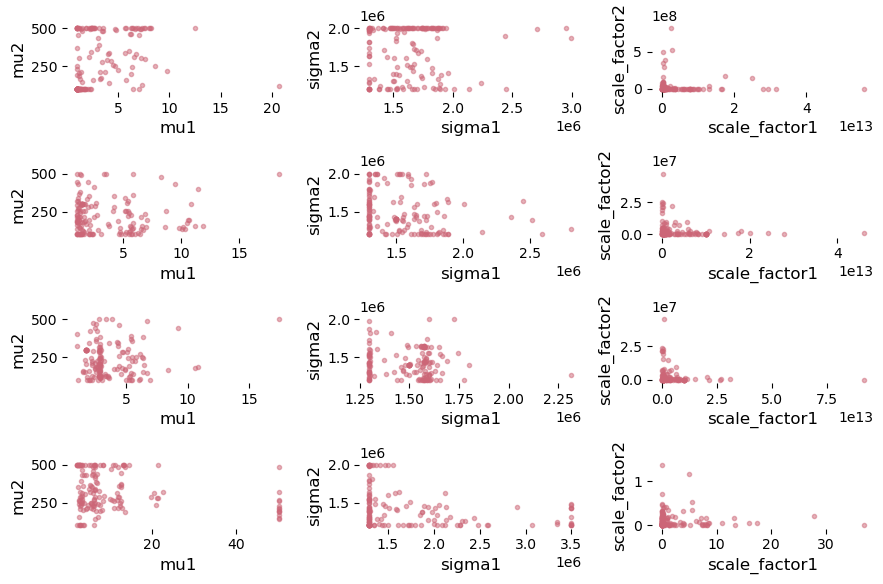

In [131]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(9, 6))

for i, ds in enumerate(
    [
        particle_size_distribution_parameters,
        weighted2_particle_size_distribution_parameters,
        weighted3_particle_size_distribution_parameters,
        mass_size_distribution_parameters,
    ]
):
    axs[i, 0].scatter(
        1e6 * ds["mu1"],
        1e6 * ds["mu2"],
        marker=".",
        alpha=0.5,
    )
    axs[i, 0].set_xlabel("mu1")
    axs[i, 0].set_ylabel("mu2")

    axs[i, 1].scatter(
        1e6 * ds["sigma1"],
        1e6 * ds["sigma2"],
        marker=".",
        alpha=0.5,
    )
    axs[i, 1].set_xlabel("sigma1")
    axs[i, 1].set_ylabel("sigma2")

    axs[i, 2].scatter(
        ds["scale_factor1"],
        ds["scale_factor2"],
        marker=".",
        alpha=0.5,
    )
    axs[i, 2].set_xlabel("scale_factor1")
    axs[i, 2].set_ylabel("scale_factor2")


fig.tight_layout()

### Distirbution of PSD and MSD

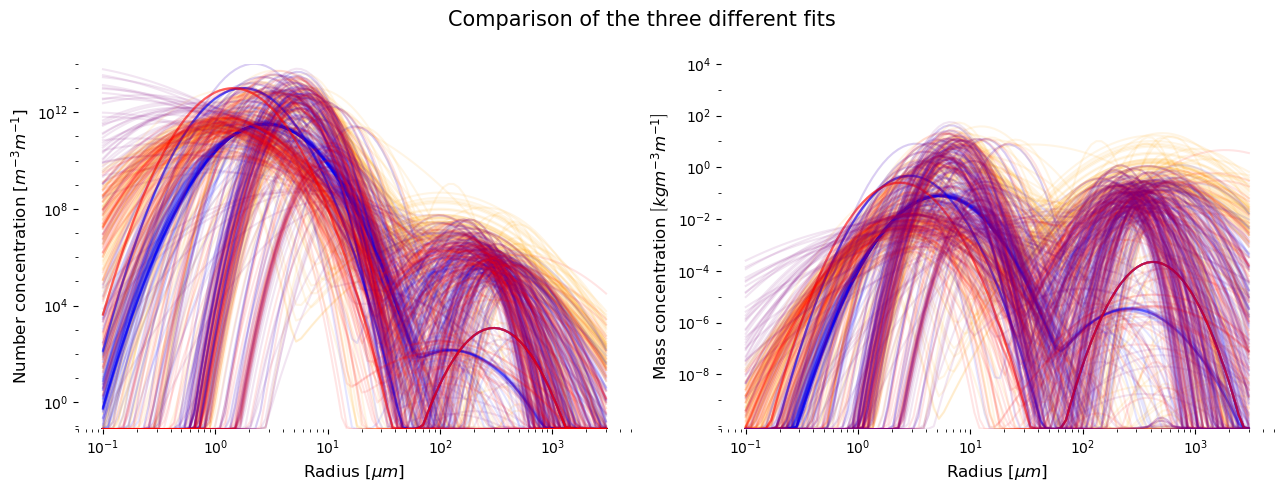

In [132]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))


# plot the particle size distribution

for key in [
    "particle_size_distribution",
    "particle_size_distribution_from_mc",
    "weighted3_particle_size_distribution",
    "weighted2_particle_size_distribution",
]:
    axs[0].plot(
        dataset_fitted["radius_micrometer"],
        dataset_fitted[key].T,
        color=colors[key],
        label=key,
        alpha=0.1,
    )

axs[0].set_xscale("log")
axs[0].set_yscale("symlog", linthresh=1e-1, linscale=0.1)
axs[0].set_yticks((1e0, 1e4, 1e8, 1e12, 1e16))
axs[0].set_ylim(0, 1e14)

axs[0].set_xlabel(label_from_attrs(dataset_fitted["radius_micrometer"]))
axs[0].set_ylabel(label_from_attrs(dataset_fitted["particle_size_distribution"]))


# plot the mass size distribution
for key in [
    "mass_size_distribution_from_nc",
    "mass_size_distribution_from_wnc3",
    "mass_size_distribution_from_wnc2",
    "mass_size_distribution",
]:
    axs[1].plot(
        dataset_fitted["radius_micrometer"],
        dataset_fitted[key].T,
        color=colors[key],
        label=key,
        alpha=0.1,
    )

axs[1].set_xscale("log")
axs[1].set_yscale("symlog", linthresh=1e-10, linscale=0.1)
axs[1].set_yticks((1e-8, 1e-6, 1e-4, 1e-2, 1e0, 1e2, 1e4))
axs[1].set_ylim(0, 1e4)


axs[1].set_xlabel(label_from_attrs(dataset_fitted["radius_micrometer"]))
axs[1].set_ylabel(label_from_attrs(dataset_fitted["mass_size_distribution"]))

fig.suptitle("Comparison of the three different fits")
fig.tight_layout()
fig.savefig("107/fit_comparison.png", dpi=300)

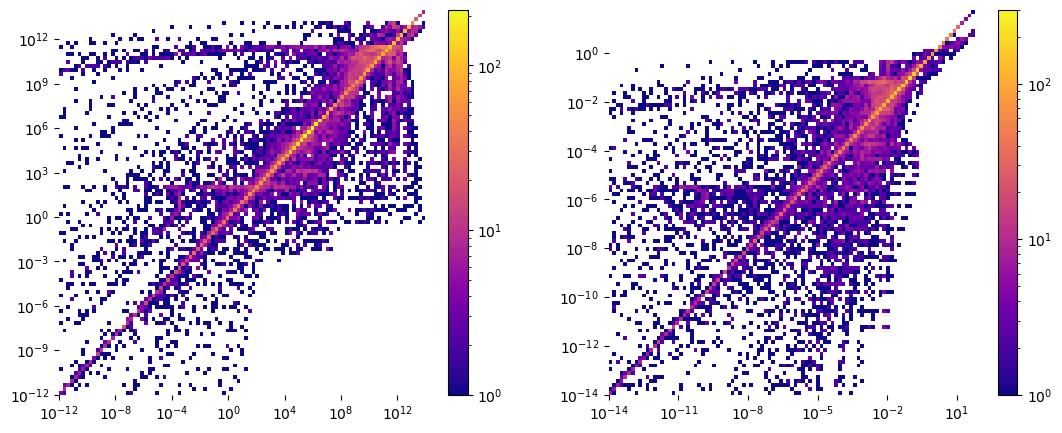

In [133]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))


im = axs[0].hist2d(
    np.ravel(dataset_fitted["particle_size_distribution_from_mc"]),
    np.ravel(dataset_fitted["weighted3_particle_size_distribution"]),
    bins=np.geomspace(1e-12, 1e14, 100),
    cmap="plasma",
    norm=mcolors.LogNorm(),
)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
fig.colorbar(im[-1], ax=axs[0])

im = axs[1].hist2d(
    np.ravel(dataset_fitted["mass_size_distribution"]),
    np.ravel(dataset_fitted["mass_size_distribution_from_wnc3"]),
    bins=np.geomspace(1e-14, 6e1, 100),
    cmap="plasma",
    norm=mcolors.LogNorm(vmin=1, vmax=300),
)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
fig.colorbar(im[-1], ax=axs[1])

## Analysis of the fits

### Compare the LWC from the fits to the observations

##### Full radius range

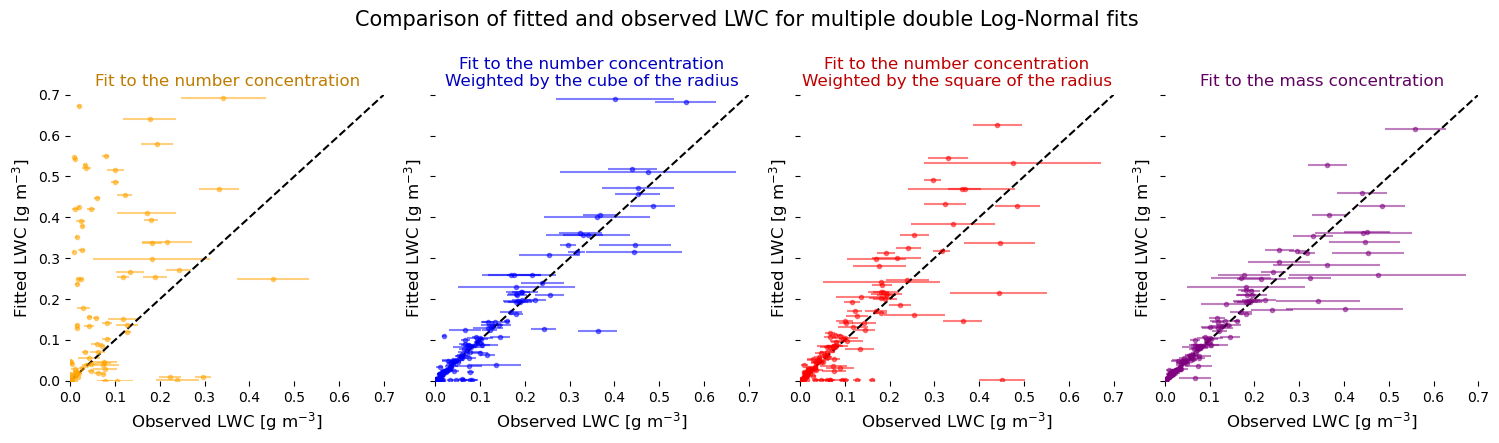

In [134]:
fig, axs = plt.subplots(ncols=4, figsize=(15, 4.5), sharex=True, sharey=True)

i = 0
for key in (
    "mass_size_distribution_from_nc",
    "mass_size_distribution_from_wnc3",
    "mass_size_distribution_from_wnc2",
    "mass_size_distribution",
):

    lwc = 1e3 * (dataset_fitted[key] * dataset_fitted["bin_width"]).sum("radius")

    axs[i].errorbar(
        x=ds_observations["liquid_water_content"],
        xerr=ds_observations["liquid_water_content_sem"],
        y=lwc,
        yerr=0,
        marker=".",
        linestyle="None",
        label=dataset_fitted[key].attrs["comment"],
        color=colors[key],
        alpha=0.5,
    )
    axs[i].set_title(
        dataset_fitted[key].attrs["comment"],
        color=adjust_lightness_array(
            [
                colors[key],
            ],
            0.75,
        )[0],
    )

    # axs[i].set_title(dataset_fitted[key].attrs['comment'])

    i += 1


for _ax in axs:
    _ax.plot([0, 3], [0, 3], color="black", linestyle="--")
    # _ax.set_aspect('equal')
    _ax.set_xlabel("Observed LWC [g m$^{-3}$]")
    _ax.set_ylabel("Fitted LWC [g m$^{-3}$]")

fig.suptitle("Comparison of fitted and observed LWC for multiple double Log-Normal fits")

fig.tight_layout()

_ax.set_xlim(0, 5)
_ax.set_ylim(0, 5)

fig.savefig("107/LWC_fit_comparison.png", dpi=400)

_ax.set_xlim(0, 0.7)
_ax.set_ylim(0, 0.7)

fig.savefig("107/LWC_fit_comparison_zoom.png", dpi=400)

##### Radii larger than 50 µm

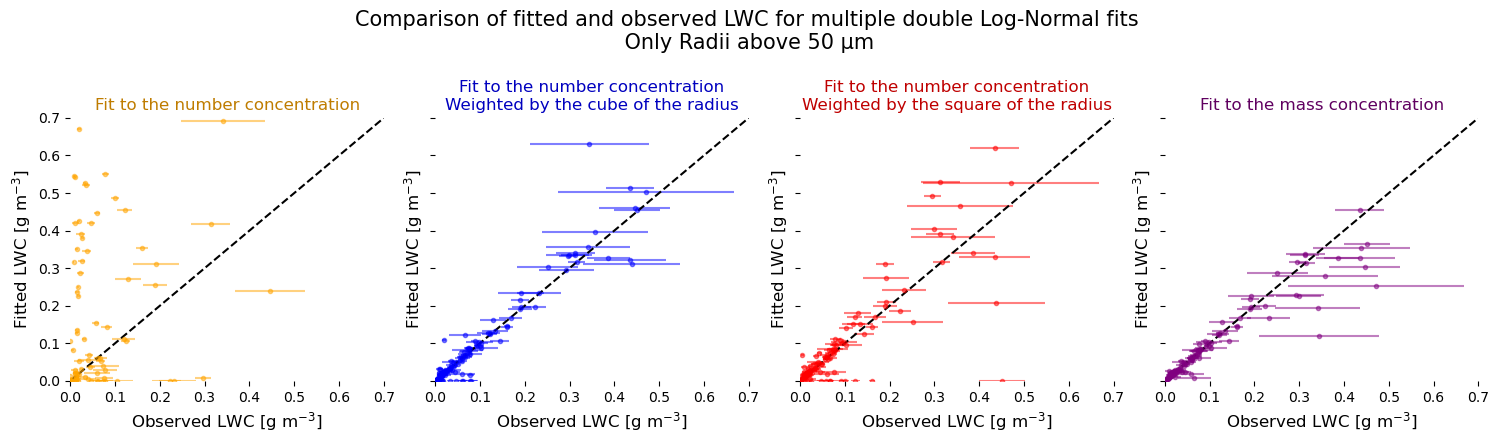

In [135]:
fig, axs = plt.subplots(ncols=4, figsize=(15, 4.5), sharex=True, sharey=True)

i = 0
for key in (
    "mass_size_distribution_from_nc",
    "mass_size_distribution_from_wnc3",
    "mass_size_distribution_from_wnc2",
    "mass_size_distribution",
):

    lwc = 1e3 * (dataset_fitted[key] * dataset_fitted["bin_width"]).sel(radius=slice(50e-6, None)).sum(
        "radius"
    )

    axs[i].errorbar(
        x=1e3 * ds_observations["liquid_water_content_50um"],
        xerr=1e3 * ds_observations["liquid_water_content_50um_sem"],
        y=lwc,
        yerr=0,
        marker=".",
        linestyle="None",
        label=dataset_fitted[key].attrs["comment"],
        color=colors[key],
        alpha=0.5,
    )

    axs[i].set_title(
        dataset_fitted[key].attrs["comment"],
        color=adjust_lightness_array(
            [
                colors[key],
            ],
            0.75,
        )[0],
    )
    i += 1

for _ax in axs:
    _ax.plot([0, 3], [0, 3], color="black", linestyle="--")
    # _ax.set_aspect('equal')
    _ax.set_xlabel("Observed LWC [g m$^{-3}$]")
    _ax.set_ylabel("Fitted LWC [g m$^{-3}$]")

fig.suptitle(
    "Comparison of fitted and observed LWC for multiple double Log-Normal fits\n Only Radii above 50 µm"
)

fig.tight_layout()

_ax.set_xlim(0, 5)
_ax.set_ylim(0, 5)

fig.savefig("107/LWC_fit_comparison-50um.png", dpi=400)

_ax.set_xlim(0, 0.7)
_ax.set_ylim(0, 0.7)

fig.savefig("107/LWC_fit_comparison-50um-zoom.png", dpi=400)

### Compare NBC from the fits with the observations

##### Full radius range

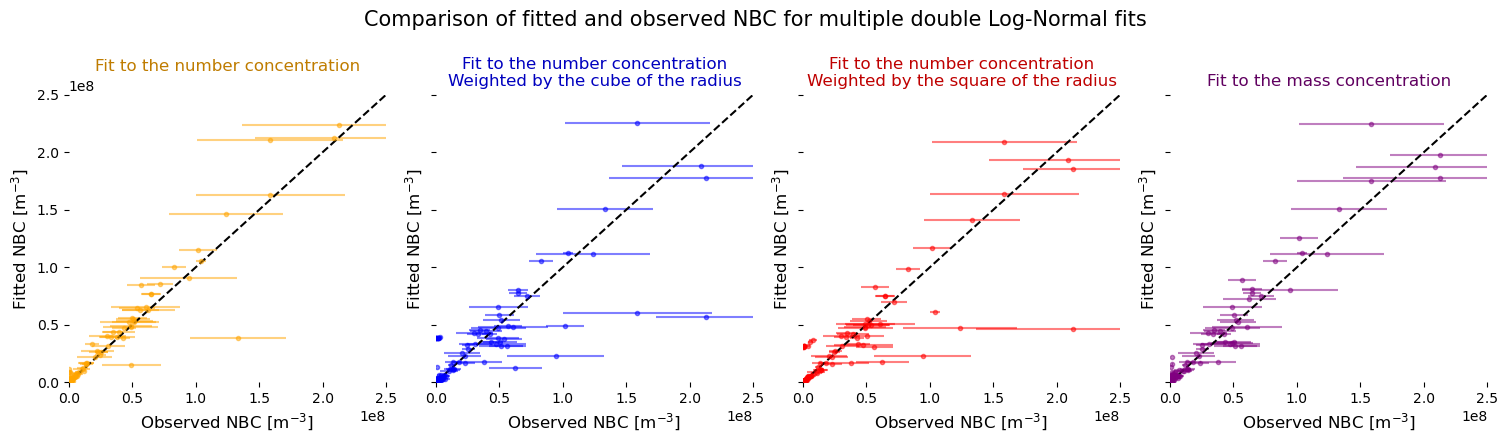

In [136]:
fig, axs = plt.subplots(ncols=4, figsize=(15, 4.5), sharex=True, sharey=True)

i = 0
for key in (
    "particle_size_distribution",
    "weighted3_particle_size_distribution",
    "weighted2_particle_size_distribution",
    "particle_size_distribution_from_mc",
):

    nbc = (dataset_fitted[key] * dataset_fitted["bin_width"]).sum("radius")

    axs[i].errorbar(
        x=ds_observations["particle_size_distribution"],
        xerr=ds_observations["particle_size_distribution_sem"],
        y=nbc,
        yerr=0,
        marker=".",
        linestyle="None",
        label=dataset_fitted[key].attrs["comment"],
        color=colors[key],
        alpha=0.5,
    )
    axs[i].set_title(
        dataset_fitted[key].attrs["comment"],
        color=adjust_lightness_array(
            [
                colors[key],
            ],
            0.75,
        )[0],
    )

    # axs[i].set_title(dataset_fitted[key].attrs['comment'])

    i += 1


for _ax in axs:

    _ax.plot([0, 8e8], [0, 8e8], color="black", linestyle="--")
    # _ax.set_aspect('equal')
    _ax.set_xlabel("Observed NBC [m$^{-3}$]")
    _ax.set_ylabel("Fitted NBC [m$^{-3}$]")

fig.suptitle("Comparison of fitted and observed NBC for multiple double Log-Normal fits")

fig.tight_layout()

_ax.set_xlim(0, 8e8)
_ax.set_ylim(0, 8e8)

fig.savefig("107/NBC_fit_comparison.png", dpi=400)

_ax.set_xlim(0, 2.5e8)
_ax.set_ylim(0, 2.5e8)

fig.savefig("107/NBC_fit_comparison_zoom.png", dpi=400)

##### Radii larger than 50 µm

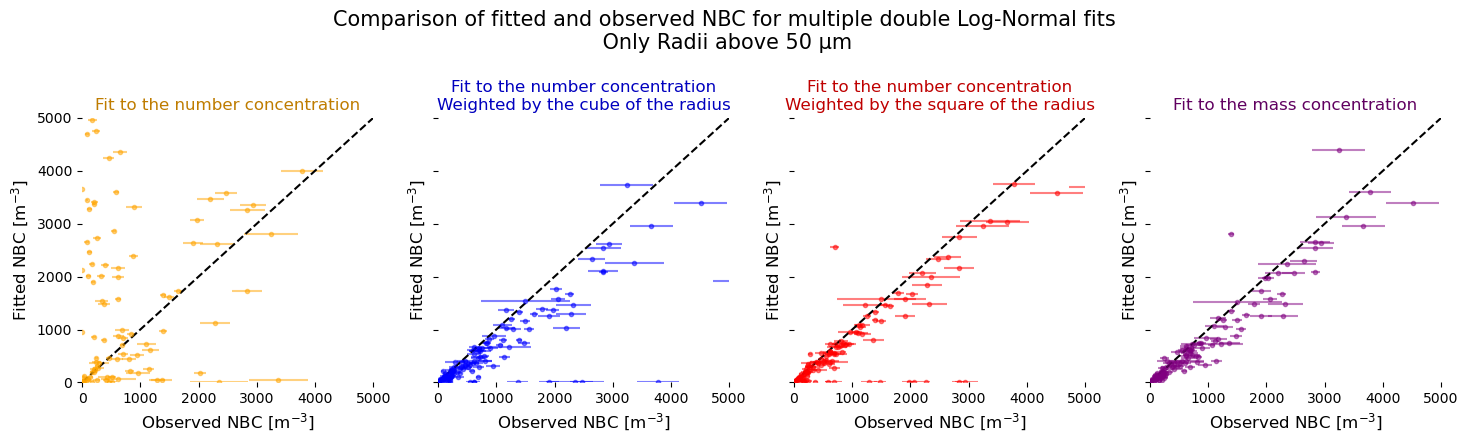

In [137]:
fig, axs = plt.subplots(ncols=4, figsize=(15, 4.5), sharex=True, sharey=True)

i = 0
for key in (
    "particle_size_distribution",
    "weighted3_particle_size_distribution",
    "weighted2_particle_size_distribution",
    "particle_size_distribution_from_mc",
):

    nbc = (dataset_fitted[key].sel(radius=slice(50e-6, None)) * dataset_fitted["bin_width"]).sum(
        "radius"
    )

    axs[i].errorbar(
        x=ds_observations["particle_size_distribution_50um"],
        xerr=ds_observations["particle_size_distribution_50um_sem"],
        y=nbc,
        yerr=0,
        marker=".",
        linestyle="None",
        label=dataset_fitted[key].attrs["comment"],
        color=colors[key],
        alpha=0.5,
    )
    axs[i].set_title(
        dataset_fitted[key].attrs["comment"],
        color=adjust_lightness_array(
            [
                colors[key],
            ],
            0.75,
        )[0],
    )

    # axs[i].set_title(dataset_fitted[key].attrs['comment'])

    i += 1


for _ax in axs:

    _ax.plot([0, 2e5], [0, 2e5], color="black", linestyle="--")
    # _ax.set_aspect('equal')
    _ax.set_xlabel("Observed NBC [m$^{-3}$]")
    _ax.set_ylabel("Fitted NBC [m$^{-3}$]")

fig.suptitle(
    "Comparison of fitted and observed NBC for multiple double Log-Normal fits\n Only Radii above 50 µm"
)

fig.tight_layout()

_ax.set_xlim(0, 20e3)
_ax.set_ylim(0, 20e3)


# _ax.set_xscale("log")
# _ax.set_yscale("log")
fig.savefig("107/NBC_fit_comparison-50um.png", dpi=400)

_ax.set_xlim(0, 5e3)
_ax.set_ylim(0, 5e3)

fig.savefig("107/NBC_fit_comparison-50um-zoom.png", dpi=400)

### Plot distributions of some random clouds

In [138]:
small_cloud_ids = np.random.choice(identified_clusters["cloud_id"], 3, replace=False)

large_cloud_ids = identified_clusters["cloud_id"].where(
    identified_clusters["liquid_water_content"] / identified_clusters["duration"].dt.seconds > 0.5,
    drop=True,
)
large_cloud_ids = np.random.choice(large_cloud_ids, 3, replace=False)

cloud_ids = np.concatenate([small_cloud_ids, large_cloud_ids])

ncols_nrows = ncols_nrows_from_N(len(cloud_ids))

##### Particle size distirbution

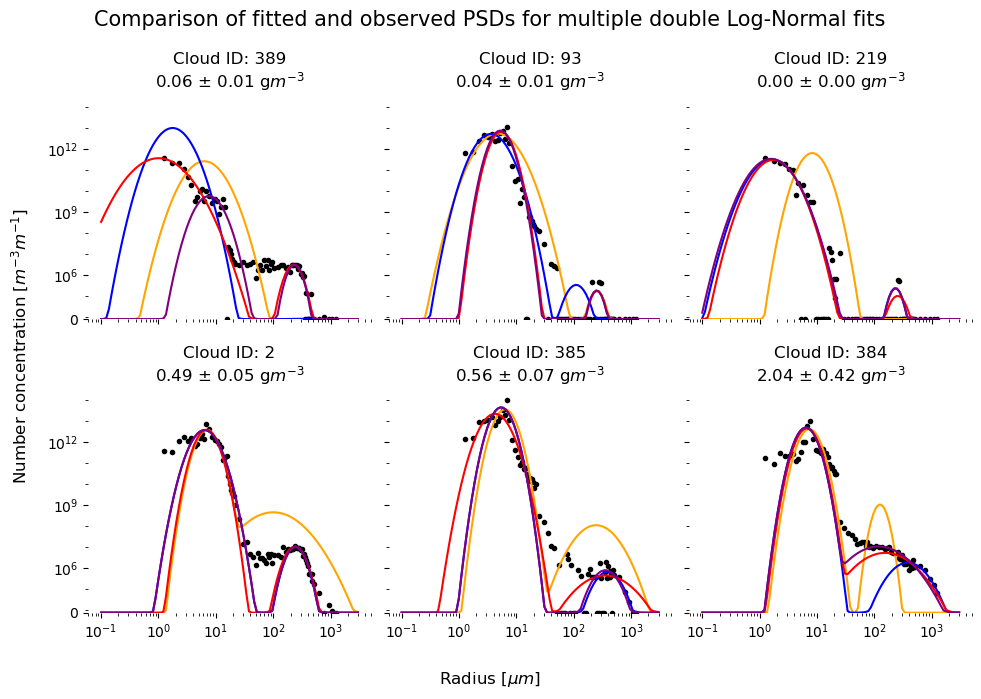

In [139]:
fig, axs = plt.subplots(figsize=(10, 7), sharex=True, sharey=True, **ncols_nrows)

# plot the PSDs of the selected clouds
for i, cloud_id in enumerate(cloud_ids):
    _ax = axs.flatten()[i]
    cc = match_clouds_and_cloudcomposite(
        ds_clouds=identified_clusters.sel(cloud_id=cloud_id),
        ds_cloudcomposite=coarse_composite,
    )

    lwc_mean, lwc_sem = mean_and_stderror_of_mean(cc["liquid_water_content"], dims=("time",))

    _ax.set_title(
        f"Cloud ID: {cloud_id:.0f}\n{lwc_mean.values:.2f} ± {lwc_sem.values:.2f} g" + "$m^{-3}$"
    )

    observations = cc["particle_size_distribution"]

    _ax.plot(
        1e6 * observations["radius"],
        observations.mean("time"),
        marker=".",
        linestyle="None",
        color="black",
    )

    for key in (
        "particle_size_distribution",
        "weighted3_particle_size_distribution",
        "weighted2_particle_size_distribution",
        "particle_size_distribution_from_mc",
    ):

        fit = dataset_fitted[key].sel(cloud_id=cloud_id)
        _ax.plot(
            dataset_fitted["radius_micrometer"],
            fit,
            color=colors[key],
            linestyle="-",
            label=fit.attrs["comment"],
        )

    _ax.set_xscale("log")
    _ax.set_yscale("symlog", linthresh=1e4, linscale=0.1)
    _ax.set_yticks([0, 1e6, 1e9, 1e12])
# axs.flatten()[0].legend()
_ax.set_ylim(0, None)

fig.supxlabel(label_from_attrs(dataset_fitted["radius_micrometer"]))
fig.supylabel(label_from_attrs(dataset_fitted["particle_size_distribution"]))

fig.suptitle("Comparison of fitted and observed PSDs for multiple double Log-Normal fits")
fig.tight_layout()

fig.savefig("107/PSD_fit_comparison.png", dpi=400)

##### Mass size distribution

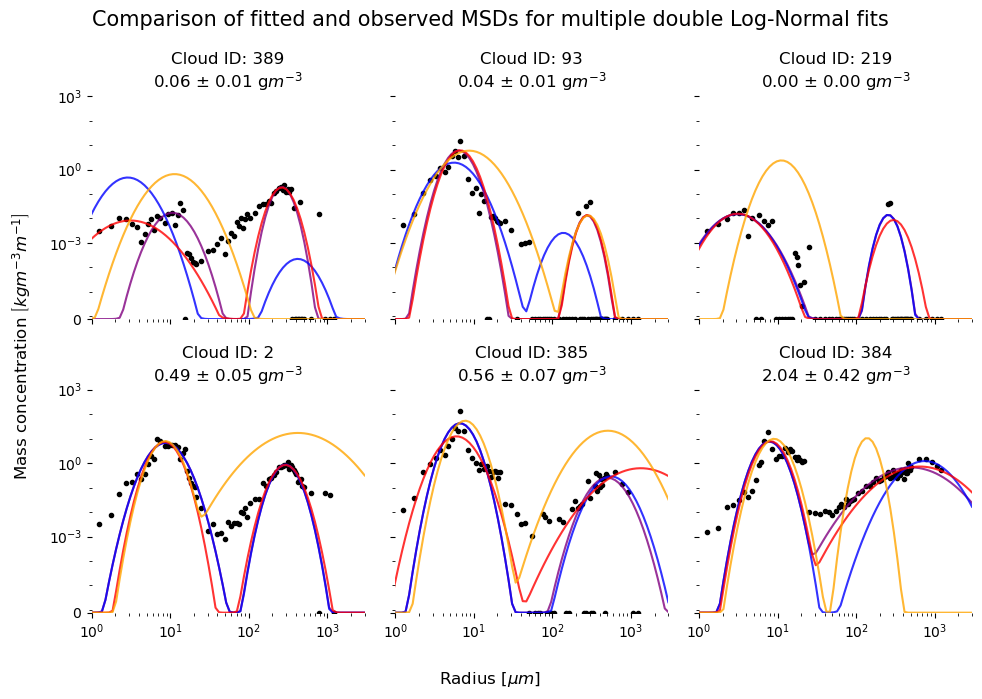

In [140]:
fig, axs = plt.subplots(figsize=(10, 7), sharex=True, sharey=True, **ncols_nrows)

# plot the PSDs of the selected clouds
for i, cloud_id in enumerate(cloud_ids):
    _ax = axs.flatten()[i]
    cc = match_clouds_and_cloudcomposite(
        ds_clouds=identified_clusters.sel(cloud_id=cloud_id),
        ds_cloudcomposite=coarse_composite,
    )

    lwc_mean, lwc_sem = mean_and_stderror_of_mean(cc["liquid_water_content"], dims=("time",))

    _ax.set_title(
        f"Cloud ID: {cloud_id:.0f}\n{lwc_mean.values:.2f} ± {lwc_sem.values:.2f} g" + "$m^{-3}$"
    )

    observations = cc["mass_size_distribution"]

    _ax.plot(1e6 * cc["radius"], observations.mean("time"), marker=".", linestyle="None", color="black")

    for key in (
        "mass_size_distribution",
        "mass_size_distribution_from_wnc3",
        "mass_size_distribution_from_wnc2",
        "mass_size_distribution_from_nc",
    ):

        fit = dataset_fitted[key].sel(cloud_id=cloud_id)
        _ax.plot(
            dataset_fitted["radius_micrometer"],
            fit,
            color=colors[key],
            linestyle="-",
            alpha=0.8,
        )

    _ax.set_xscale("log")
    _ax.set_yscale("symlog", linthresh=1e-6, linscale=0.1)
    _ax.set_yticks([0, 1e-3, 1e0, 1e3])
    _ax.set_xlim(1, 3e3)
_ax.set_ylim(0, None)

fig.supxlabel("Radius [$µm$]")
fig.supylabel(label_from_attrs(dataset_fitted["mass_size_distribution"]))

fig.suptitle("Comparison of fitted and observed MSDs for multiple double Log-Normal fits")
fig.tight_layout()

fig.savefig("107/MSD_fit_comparison.png", dpi=400)

##### Linear axes - mass size distribution

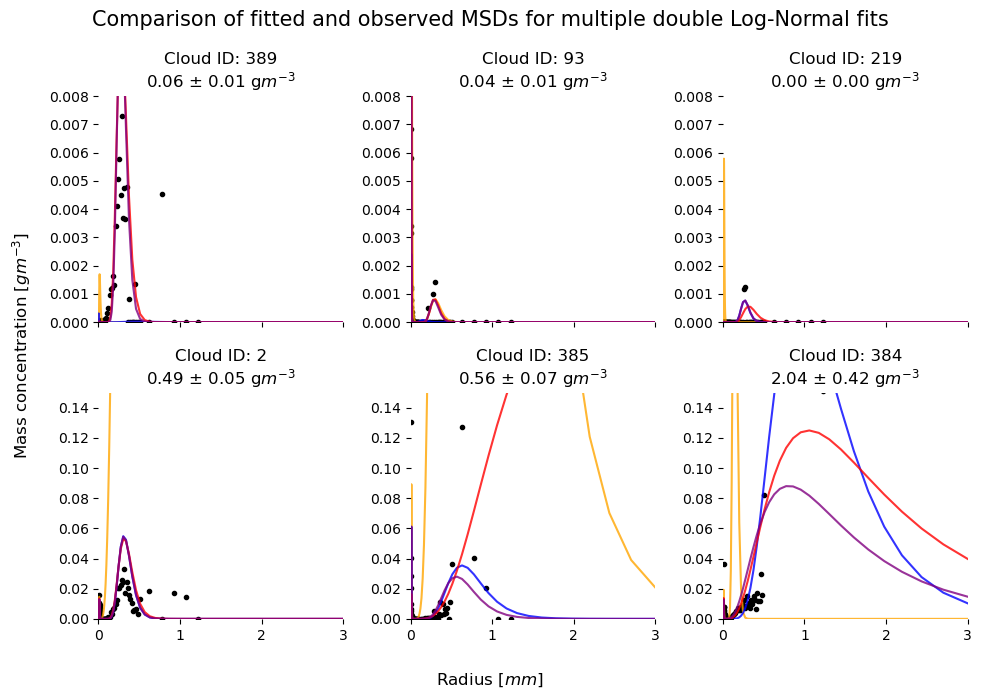

In [141]:
fig, axs = plt.subplots(figsize=(10, 7), sharex=True, sharey=False, **ncols_nrows)

# plot the PSDs of the selected clouds
for i, cloud_id in enumerate(cloud_ids):
    _ax = axs.flatten()[i]
    cc = match_clouds_and_cloudcomposite(
        ds_clouds=identified_clusters.sel(cloud_id=cloud_id),
        ds_cloudcomposite=coarse_composite,
    )

    lwc_mean, lwc_sem = mean_and_stderror_of_mean(cc["liquid_water_content"], dims=("time",))

    _ax.set_title(
        f"Cloud ID: {cloud_id:.0f}\n{lwc_mean.values:.2f} ± {lwc_sem.values:.2f} g" + "$m^{-3}$"
    )

    observations = cc["mass_size_distribution"] * cc["bin_width"]

    _ax.plot(
        1e3 * observations["radius"],
        1e3 * observations.mean("time"),
        marker=".",
        linestyle="None",
        color="black",
    )

    for key in (
        "mass_size_distribution_from_nc",
        "mass_size_distribution_from_wnc3",
        "mass_size_distribution_from_wnc2",
        "mass_size_distribution",
    ):

        fit = dataset_fitted[key].sel(cloud_id=cloud_id)
        _ax.plot(
            1e3 * dataset_fitted["radius"],
            1e3 * fit * dataset_fitted["bin_width"],
            color=colors[key],
            linestyle="-",
            label=fit.attrs["comment"],
            alpha=0.8,
        )
    _ax.set_xlim([0, 3])

    # _ax.set_xscale('log')
# _ax.set_yscale('symlog', linthresh = 1e4)
for _ax in axs[0]:
    _ax.set_ylim(0, 0.008)

for _ax in axs[1]:
    _ax.set_ylim(0, 0.15)


fig.supxlabel("Radius [$mm$]")
fig.supylabel("Mass concentration [$g m^{-3}$]")

fig.suptitle("Comparison of fitted and observed MSDs for multiple double Log-Normal fits")
fig.tight_layout()

fig.savefig("107/MSD_fit_comparison_linear.png", dpi=400)

# Decide for the correct fits to use

We think, that the best solution would be the:
- <span style="color:#8A2BE2">**Mass Concentration fit**</span>

The easiest and still good estimate is the 
- <span style="color:#6495ED">**Number Concentration fit with weight to $r^3$**</span>

In [142]:
output_dir = data_dir / Path("model/inputv4.0")
output_dir.mkdir(exist_ok=True)

dataset_fitted.to_netcdf(output_dir / Path("fitted_distributions.nc"))

mass_size_distribution_parameters.to_netcdf(output_dir / Path("mass_size_distribution_parameters.nc"))
weighted3_particle_size_distribution_parameters.to_netcdf(
    output_dir / Path("particle_size_distribution_parameters.nc")
)

ds_observations.to_netcdf(output_dir / Path("lwc_and_nbc_cloud_composite.nc"))